In [31]:
# import neccessary libraries
import os  # file and directory operations
import gensim # NLP and word embedding models
import zipfile # unzip file
import numpy as np
import re # regular expressions and text processing
import nltk  # NLP toolkit
import pandas as pd # handle structured data using DataFrames
import gensim.downloader as api # download pre-trained word embedding models

# import specific functions and classes

from gensim.utils import simple_preprocess # basic text preprocessing (lowercasing, tokenizing, removing punctuation)
from gensim.models import KeyedVectors # work with word embedding models
from sklearn.metrics.pairwise import cosine_similarity # compute similarity score
from nltk.corpus import stopwords # handle stopwords
from tabulate import tabulate # format and display table

In [32]:
# download stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Exploring the Dataset

In [33]:
# download dataset
!gdown "https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c4147f9_data/data.zip" -O data.zip
# extract zip file
with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

Downloading...
From: https://s3.amazonaws.com/video.udacity-data.com/topher/2019/January/5c4147f9_data/data.zip
To: /content/data.zip
100% 114k/114k [00:00<00:00, 991kB/s]


In [53]:
# Load file information
extract_path = "data"
file_info_path = os.path.join(extract_path, "file_information.csv")
file_info_df = pd.read_csv(file_info_path)

# filter file with .txt
txt_files = file_info_df[file_info_df['File'].str.endswith('.txt')]['File'].tolist()

              File Task Category
0   g0pA_taska.txt    a      non
1   g0pA_taskb.txt    b      cut
2   g0pA_taskc.txt    c    light
3   g0pA_taskd.txt    d    heavy
4   g0pA_taske.txt    e      non
..             ...  ...      ...
95  orig_taska.txt    a     orig
96  orig_taskb.txt    b     orig
97  orig_taskc.txt    c     orig
98  orig_taskd.txt    d     orig
99  orig_taske.txt    e     orig

[100 rows x 3 columns]


In [63]:
# file_info_df contain information of file_information.csv
explore_file = pd.DataFrame(file_info_df)
explore_file

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non
...,...,...,...
95,orig_taska.txt,a,orig
96,orig_taskb.txt,b,orig
97,orig_taskc.txt,c,orig
98,orig_taskd.txt,d,orig


In [64]:
# number of unique tasks and categories
num_unique_tasks = explore_file["Task"].nunique()
num_unique_categories = explore_file["Category"].nunique()

print(f"Number of unique tasks: {num_unique_tasks}")
print(f"Number of unique categories: {num_unique_categories}")

Number of unique tasks: 5
Number of unique categories: 5


#### Based on the information from file_info_df, we can see that there are 5 unique tasks, 5 unique categories, and 100 text files

In [35]:
# read dataset files
def read_documents(directory, file_list):
    documents = []
    filenames = []
    for filename in file_list:
        file_path = os.path.join(directory, filename)  # full path
        if os.path.exists(file_path):  # check if file exists
            try:
                with open(file_path, 'r', encoding='utf-8') as file:
                    documents.append(file.read())
            except UnicodeDecodeError:
                with open(file_path, 'r', encoding='latin-1') as file:
                    documents.append(file.read())
            filenames.append(filename)

# documents: List of document contents
# filenames: List of corresponding file paths
    return documents, filenames # return the list of document content and filename

# read extracted documents
documents, filenames = read_documents(extract_path, txt_files)

In [48]:
# convert to dataframe with 2 columns: filename and content
df = pd.DataFrame({'filename': filenames, 'content': documents})
# print 5 first rows
df.head()

,filename,content
0,g0pA_taska.txt,Inheritance is a basic concept of Object-Orien...
1,g0pA_taskb.txt,PageRank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,"The vector space model (also called, term vect..."
3,g0pA_taskd.txt,Bayes’ theorem was names after Rev Thomas Baye...
4,g0pA_taske.txt,Dynamic Programming is an algorithm design tec...


### Build a class for computing document similarity ('DocSim' class)

In [37]:
class DocSim:
    # initialize the Docsim class with a word embedding model and an optional stopword list
    def __init__(self, model, stopwords=None):
        self.model = model
        self.stopwords = stopwords if stopwords else set()
         # cache to store computed vectors for faster similarity calculations.
        self.vector_cache = {}

    def preprocess(self, text):
        # tokenize and preprocesses the input text using gensim's simple_preprocess
        # simple preprocess: convert text to lowercase; removes punctuation and special characters, exclude stopwords

        return [
            word for word in simple_preprocess(text)
            if word not in self.stopwords
        ]

    def vectorize(self, words):
      # convert a lits of words into a single vector representation
        if not words:
            return None  # avoid vector zero

        # get vectors for words that exist in the model's vocabulary
        vectors = [self.model[word] for word in words if word in self.model]
        if not vectors:
            return None
        # compute the mean of all word vectors
        return np.mean(vectors, axis=0)

    # compute the cosine similarity between two text documents
    def similarity(self, text1, text2):
        # cache vectors, retrieve cached vectors or compute if not available
        vec1 = self.vector_cache.get(text1, self.vectorize(self.preprocess(text1)))
        vec2 = self.vector_cache.get(text2, self.vectorize(self.preprocess(text2)))

        # if any document is empty, return 0 similarity
        if vec1 is None or vec2 is None:
            return 0.0

        # compute cosine similarity between the two vectors
        return cosine_similarity([vec1], [vec2])[0][0]

### Load the pre-trained word embedding model

In [38]:
# load the pre-trained Word2Vec model
model = api.load("word2vec-google-news-300")

# create stopwords list
stopwords = set(stopwords.words('english'))

# initialize DocSim instance
doc_sim = DocSim(model, stopwords)

### Plagiarism Detection and Evaluation
##### Run plagiarism detection by comparing all pairs of text files. This section iterates through all text files in the dataset and computes similarity scores.
#####  For each pair using a pre-trained word embedding model (e.g., Word2Vec).
#####  Cosine similarity is used to measure how similar two documents are.
#####  If the similarity score is above a specified threshold (e.g., 0.7), the results will be stored in a structured format and displayed in a table.

In [39]:
# detect plagiarism function using cosine similarity
def detect_plagiarism(docs, filenames, threshold=0.7):
    results = []
    num_docs = len(docs)

    # iterate over each document
    for i in range(num_docs):
      # compare each document with all subsequent documents, avoid self-comparison and duplicate pairs
        for j in range(i + 1, num_docs):
            sim = doc_sim.similarity(docs[i], docs[j]) # compute similarity score

            # if similarity exceeds threshold, store the result
            if sim >= threshold:
                results.append((filenames[i], filenames[j], sim))

    return results

In [40]:
# compare all document pairs and return a list of suspected plagiarized pairs
results = detect_plagiarism(documents, filenames)

In [41]:
# print the result
print("Plagiarism Detection Results:")
for sus_name, best_match, score in results:
    print(f"{sus_name} is similar to {best_match} with similarity: {score}")

Plagiarism Detection Results:
g0pA_taska.txt is similar to g0pA_taskd.txt with similarity: 0.7152873873710632
g0pA_taska.txt is similar to g0pB_taska.txt with similarity: 0.7907620072364807
g0pA_taska.txt is similar to g0pC_taska.txt with similarity: 0.8082267045974731
g0pA_taska.txt is similar to g0pC_taske.txt with similarity: 0.7048723697662354
g0pA_taska.txt is similar to g0pD_taska.txt with similarity: 0.7844691276550293
g0pA_taska.txt is similar to g0pE_taska.txt with similarity: 0.7918136715888977
g0pA_taska.txt is similar to g1pA_taska.txt with similarity: 0.7756093740463257
g0pA_taska.txt is similar to g1pB_taska.txt with similarity: 0.745990514755249
g0pA_taska.txt is similar to g1pB_taske.txt with similarity: 0.7167867422103882
g0pA_taska.txt is similar to g1pD_taska.txt with similarity: 0.7873114347457886
g0pA_taska.txt is similar to g2pA_taska.txt with similarity: 0.7988606691360474
g0pA_taska.txt is similar to g2pA_taskd.txt with similarity: 0.7314215302467346
g0pA_taska.

In [42]:
# convert results into dataframe
df_results = pd.DataFrame(results, columns=["File 1", "File 2", "Similarity Score"])

# round the similarity score to 2 decimal places
df_results["Similarity Score"] = df_results["Similarity Score"].apply(lambda x: round(x, 2))

# print the table
print(tabulate(df_results, headers="keys", tablefmt="grid"))


+------+----------------+----------------+--------------------+
|      | File 1         | File 2         |   Similarity Score |
+======+================+================+====================+
|    0 | g0pA_taska.txt | g0pA_taskd.txt |               0.72 |
+------+----------------+----------------+--------------------+
|    1 | g0pA_taska.txt | g0pB_taska.txt |               0.79 |
+------+----------------+----------------+--------------------+
|    2 | g0pA_taska.txt | g0pC_taska.txt |               0.81 |
+------+----------------+----------------+--------------------+
|    3 | g0pA_taska.txt | g0pC_taske.txt |               0.7  |
+------+----------------+----------------+--------------------+
|    4 | g0pA_taska.txt | g0pD_taska.txt |               0.78 |
+------+----------------+----------------+--------------------+
|    5 | g0pA_taska.txt | g0pE_taska.txt |               0.79 |
+------+----------------+----------------+--------------------+
|    6 | g0pA_taska.txt | g1pA_taska.txt

### Evaluation
##### Since there is no ground truth, traditional evaluation metrics like precision, recall, and F1-score cannot be used. Instead, we rely on statistical analysis of the histogram to interpret the performance of the plagiarism detection system.

Mean Similarity Score: 0.80
Standard Deviation: 0.07


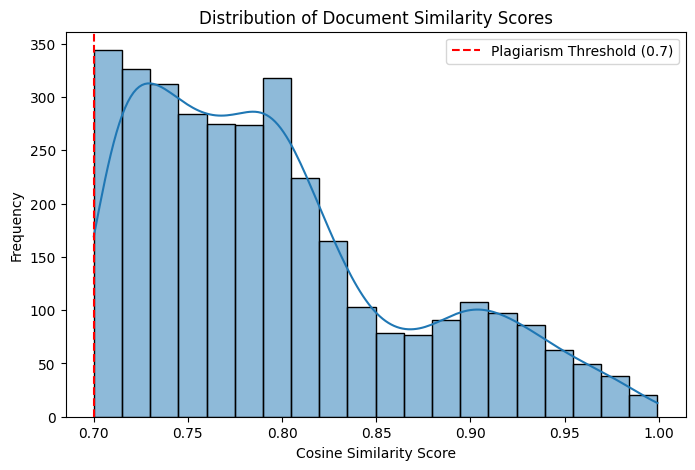

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# extract similarity scores from results
similarity_scores = [sim for _, _, sim in results]
mean_score = np.mean(similarity_scores)
std_dev = np.std(similarity_scores)

print(f"Mean Similarity Score: {mean_score:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")

# Plot histogram with density curve
plt.figure(figsize=(8, 5))
sns.histplot(similarity_scores, bins=20, kde=True)

# Add threshold line
plt.axvline(x=0.7, color='red', linestyle='dashed', label="Plagiarism Threshold (0.7)")

# Labels
plt.xlabel("Cosine Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Document Similarity Scores")
plt.legend()
plt.show()


### Conclusion
The histogram of document similarity scores shows that the majority of document pairs have **high cosine similarity**, with a **mean similarity score of 0.80** and a **standard deviation of 0.07**. This indicates that most document pairs are **highly similar**, with scores concentrated around **0.80**.